<a href="https://colab.research.google.com/github/KevinCandra9999/colab-test/blob/main/notebooks/Recognizing_fashion_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch; torch.manual_seed(0)
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import random; random.seed(0)

from sklearn.metrics import classification_report
import math

In [14]:
if torch.cuda.is_available():
    print('CUDA is available. Using the GPU.')
    device = torch.device('cuda')
else:
    print('CUDA is not available. Using the CPU.')
    device = torch.device('cpu')

CUDA is available. Using the GPU.


In [15]:
train_dataset = torchvision.datasets.FashionMNIST(
    './train',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

val_dataset = torchvision.datasets.FashionMNIST(
    './val',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [16]:
batch_size = 128  # to be changed to 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

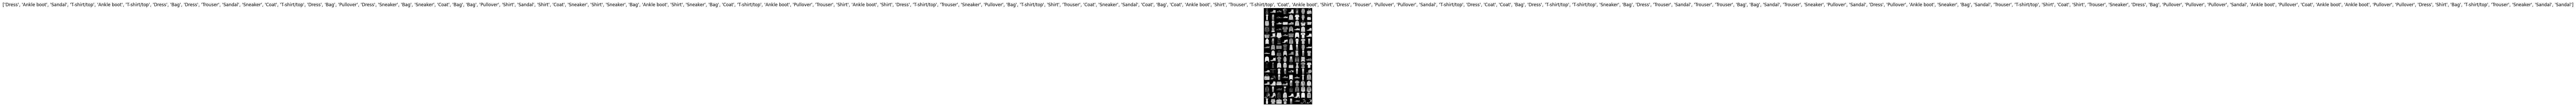

In [17]:
for images, labels in train_loader:
    grid = torchvision.utils.make_grid(images)

    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    # Print out actual labels instead of label indices.
    #plt.title(labels.numpy())  # label indices
    plt.title([train_dataset.classes[label] for label in labels.numpy()])

    plt.axis('off')

    plt.show()

    break

In [18]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [19]:
class DoubleLayerNet(torch.nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(DoubleLayerNet, self).__init__()
        self.hidden1 = torch.nn.Linear(28 * 28, hidden_size1)
        self.relu1 = torch.nn.ReLU()
        self.hidden2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(hidden_size2, 10)

    def forward(self, x):
        out = self.hidden1(x)
        out = self.relu1(out)
        out = self.hidden2(out)
        out = self.relu2(out)
        out = self.output(out)

        return out

In [20]:
n_epochs = 10
learning_rate = 0.0001

model = DoubleLayerNet(128, 128).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
losses = []

model.train()

for epoch in range(n_epochs):
    running_loss = 0

    for images, labels in train_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    losses.append(running_loss / len(train_loader))

    print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/10: 141.3785
Epoch 2/10: 75.9242
Epoch 3/10: 65.6654
Epoch 4/10: 60.9048
Epoch 5/10: 57.8427
Epoch 6/10: 55.4871
Epoch 7/10: 53.8335
Epoch 8/10: 52.3219
Epoch 9/10: 51.2638
Epoch 10/10: 50.1460


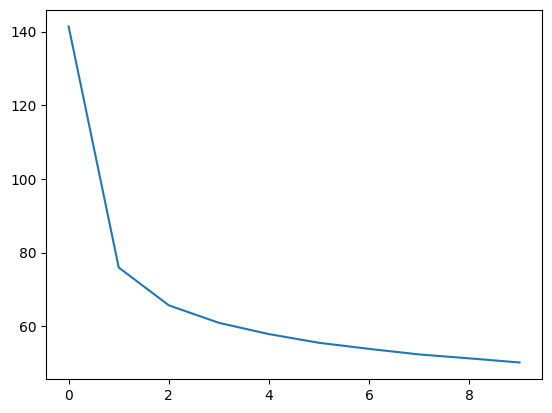

In [22]:
plt.plot(losses)
plt.show()

In [23]:
model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        y_true += list(labels.cpu().numpy())
        y_pred += list(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.81      0.81      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.70      0.81      0.75      1000
       Dress       0.82      0.88      0.85      1000
        Coat       0.75      0.75      0.75      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.70      0.53      0.60      1000
     Sneaker       0.91      0.92      0.92      1000
         Bag       0.94      0.95      0.95      1000
  Ankle boot       0.94      0.95      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [24]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 16, 3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.pooling1 = torch.nn.MaxPool2d(2)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.pooling2 = torch.nn.MaxPool2d(2)
        self.relu2 = torch.nn.ReLU()

        self.output = torch.nn.Linear(1568, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pooling1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.pooling2(out)
        out = self.relu2(out)

        out = out.view(out.size(0), -1)
        out = self.output(out)

        return out

In [25]:
n_epochs = 16

model = ConvNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
losses = []

model.train()

for epoch in range(n_epochs):
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    losses.append(running_loss / len(train_loader))

    print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/16: 162.4208
Epoch 2/16: 85.3274
Epoch 3/16: 74.7683
Epoch 4/16: 68.0407
Epoch 5/16: 63.2745
Epoch 6/16: 59.9726
Epoch 7/16: 57.3378
Epoch 8/16: 55.4002
Epoch 9/16: 53.6827
Epoch 10/16: 52.3528
Epoch 11/16: 51.1576
Epoch 12/16: 50.1528
Epoch 13/16: 49.4089
Epoch 14/16: 48.4250
Epoch 15/16: 47.6615
Epoch 16/16: 46.9915


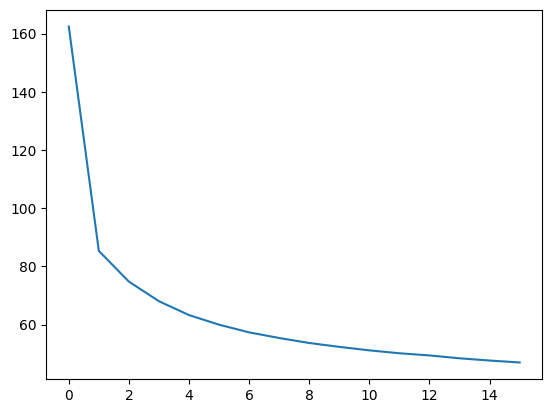

In [27]:
plt.plot(losses)
plt.show()

In [28]:
model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        y_true += list(labels.cpu().numpy())
        y_pred += list(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.87      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.78      0.79      0.78      1000
       Dress       0.87      0.88      0.87      1000
        Coat       0.76      0.77      0.76      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.66      0.56      0.61      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [29]:
class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=3,
                                    stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.relu = torch.nn.ReLU(inplace=True)

        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3,
                                     stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [30]:
class Bottleneck(torch.nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)

        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                                     padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.conv3 = torch.nn.Conv2d(planes, planes*4, kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(planes*4)

        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [31]:
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                                     bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.avgpool = torch.nn.AvgPool2d(7)
        self.fc = torch.nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.inplanes, planes * block.expansion,
                                kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes*block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [32]:
n_epochs = 10

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)  # resnet 18
#model = ResNet(BasicBlock, [3, 4, 6, 3]).to(device)  # resnet 34
#model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device)  # resnet 50
#model = ResNet(Bottleneck, [3, 4, 23, 3]).to(device)  # resnet 101
#model = ResNet(Bottleneck, [3, 8, 26, 3]).to(device)  # resnet 152

#model = torchvision.models.resnet18(pretrained=False)  # pre-implemented from torchvision

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
losses = []

model.train()

for epoch in range(n_epochs):
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    losses.append(running_loss / len(train_loader))

    print(f'Epoch {epoch + 1}/{n_epochs}: {losses[-1]:.4f}')

Epoch 1/10: 69.7218
Epoch 2/10: 36.6691
Epoch 3/10: 28.9626
Epoch 4/10: 22.9559
Epoch 5/10: 17.5333
Epoch 6/10: 12.8698
Epoch 7/10: 8.8502
Epoch 8/10: 6.2319
Epoch 9/10: 4.9887
Epoch 10/10: 3.9863


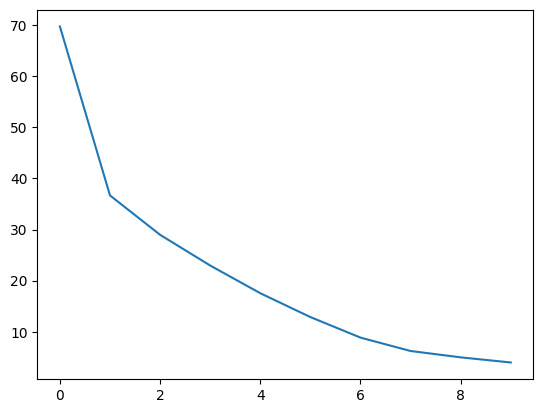

In [34]:
plt.plot(losses)
plt.show()

In [35]:
model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.to(device)  # no reshaping
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output.data, 1)

        y_true += list(labels.cpu().numpy())
        y_pred += list(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.84      0.85      1000
     Trouser       0.98      0.99      0.98      1000
    Pullover       0.88      0.84      0.86      1000
       Dress       0.90      0.91      0.91      1000
        Coat       0.83      0.89      0.86      1000
      Sandal       0.99      0.95      0.97      1000
       Shirt       0.74      0.74      0.74      1000
     Sneaker       0.92      0.99      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

